In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Conv1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

2024-02-02 10:42:35.426136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 10:42:35.494087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 10:42:35.494122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 10:42:35.495915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 10:42:35.505661: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 10:42:35.506311: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH, 'methy.csv')
mirna_path = os.path.join(BASE_PATH, 'mirna.csv')
mrna_path = os.path.join(BASE_PATH, 'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not found')

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)

In [4]:
def get_train_test(df):
    train_df = df[df['Split']==1].drop('Split', axis=1)
    test_df = df[df['Split']==0].drop('Split', axis=1)
    y_train = train_df['Label']
    y_test = test_df['Label']
    return train_df.drop('Label', axis=1), test_df.drop('Label', axis=1), y_train, y_test

In [5]:
methy_train_df, methy_test_df, methy_y_train, methy_y_test = get_train_test(methy_df)
mirna_train_df, mirna_test_df, mirna_y_train, mirna_y_test = get_train_test(mirna_df)
mrna_train_df, mrna_test_df, mrna_y_train, mrna_y_test = get_train_test(mrna_df)

print(methy_train_df.shape, mirna_train_df.shape, mrna_train_df.shape)
print(methy_test_df.shape, mirna_test_df.shape, mrna_test_df.shape)
print(methy_y_train.shape, mirna_y_train.shape, mrna_y_train.shape)
print(methy_y_test.shape, mirna_y_test.shape, mrna_y_test.shape)

(245, 200) (245, 200) (245, 200)
(106, 200) (106, 200) (106, 200)
(245,) (245,) (245,)
(106,) (106,) (106,)


In [6]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [7]:
methy_corr_features = correlation(methy_train_df, 0.85)
print('methy correlated features: ', len(methy_corr_features))
mirna_corr_features = correlation(mirna_train_df, 0.85)
print('mirna correlated features: ', len(mirna_corr_features))
mrna_corr_features = correlation(mrna_train_df, 0.85)
print('mrna correlated features: ', len(mrna_corr_features))

methy correlated features:  18
mirna correlated features:  6
mrna correlated features:  0


In [8]:
methy_train_df.drop(methy_corr_features, axis=1, inplace=True)
mirna_train_df.drop(mirna_corr_features, axis=1, inplace=True)
mrna_train_df.drop(mrna_corr_features, axis=1, inplace=True)

methy_test_df.drop(methy_corr_features, axis=1, inplace=True)
mirna_test_df.drop(mirna_corr_features, axis=1, inplace=True)
mrna_test_df.drop(mrna_corr_features, axis=1, inplace=True)

In [9]:
scaler_methy = StandardScaler()
scaler_mirna = StandardScaler()
scaler_mrna = StandardScaler()

In [10]:
methy_train_scaled = scaler_methy.fit_transform(methy_train_df)
methy_test_scaled = scaler_methy.transform(methy_test_df)

mirna_train_scaled = scaler_mirna.fit_transform(mirna_train_df)
mirna_test_scaled = scaler_mirna.transform(mirna_test_df)

mrna_train_scaled = scaler_mrna.fit_transform(mrna_train_df)
mrna_test_scaled = scaler_mrna.transform(mrna_test_df)

In [11]:
print(methy_train_scaled.shape, mirna_train_scaled.shape, mrna_train_scaled.shape)
print(methy_test_scaled.shape, mirna_test_scaled.shape, mrna_test_scaled.shape)

(245, 182) (245, 194) (245, 200)
(106, 182) (106, 194) (106, 200)


In [12]:
input_methy = Input(shape=(methy_train_scaled.shape[1],), name='methy')
input_mirna = Input(shape=(mirna_train_scaled.shape[1],), name='mirna')
input_mrna = Input(shape=(mrna_train_scaled.shape[1],), name='mrna')

In [13]:
def create_branch(input_layer):
    dense_methy = Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001))(input_layer)
    dense_methy = Dropout(0.5)(dense_methy)
    dense_methy = Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001))(dense_methy)
    dense_methy = Dropout(0.3)(dense_methy)
    dense_methy = Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001))(dense_methy)
    dense_methy = Dropout(0.2)(dense_methy)
    return dense_methy


In [14]:
methy_branch = create_branch(input_methy)
mirna_branch = create_branch(input_mirna)
mrna_branch = create_branch(input_mrna)


2024-02-02 10:42:40.866864: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
merged = Concatenate()([methy_branch, mirna_branch, mrna_branch])

merged_dense = Dense(112, activation='relu', kernel_regularizer=regularizers.l1(0.001),name = "merged_1" )(merged)
merged_dense = Dropout(0.438687619)(merged_dense)
merged_dense = Dense(49, activation='relu', kernel_regularizer=regularizers.l1(0.001), name = "merged_2")(merged_dense)
merged_dense = Dropout(0.193897159)(merged_dense)
merged_dense = Dense(63, activation='relu', kernel_regularizer=regularizers.l1(0.001), name = "merged_3")(merged_dense)
merged_dense = Dropout(0.154345902)(merged_dense)
# merged_dense = Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001))(merged_dense)
# merged_dense = Dropout(0.2)(merged_dense)

output = Dense(1, activation='sigmoid', name = "merged_out")(merged_dense)
# output = Dense(1)(merged_dense)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.023718015)

In [17]:
model = Model(inputs=[input_methy, input_mirna, input_mrna], outputs=output)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [18]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit([methy_train_scaled, mirna_train_scaled, mrna_train_scaled], 
          methy_y_train, 
          epochs=500, 
          batch_size=32, 
          validation_data=([methy_test_scaled, mirna_test_scaled, mrna_test_scaled], methy_y_test),
          callbacks=[EarlyStopping(monitor= 'val_loss', patience=50, restore_best_weights=True)])

Epoch 1/500
8/8 [==============================] - 3s 65ms/step - loss: 9.5322 - accuracy: 0.4857 - val_loss: 8.1353 - val_accuracy: 0.5472
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 7.6510 - accuracy: 0.5714 - val_loss: 6.6060 - val_accuracy: 0.7170
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 5.8635 - accuracy: 0.6041 - val_loss: 4.7600 - val_accuracy: 0.8208
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 4.4563 - accuracy: 0.6653 - val_loss: 3.9623 - val_accuracy: 0.7075
Epoch 5/500
8/8 [==============================] - 0s 11ms/step - loss: 3.7315 - accuracy: 0.5918 - val_loss: 3.2319 - val_accuracy: 0.6887
Epoch 6/500
8/8 [==============================] - 0s 9ms/step - loss: 2.9263 - accuracy: 0.6327 - val_loss: 2.4526 - val_accuracy: 0.7358
Epoch 7/500
8/8 [==============================] - 0s 10ms/step - loss: 2.3074 - accuracy: 0.6571 - val_loss: 2.0459 - val_accuracy: 0.7170
Epoch 8/500
8/8 [======

In [20]:
y_pred = model.predict([methy_test_scaled, mirna_test_scaled, mrna_test_scaled])
y_pred = np.where(y_pred > 0.5, 1, 0)
print('Accuracy:', accuracy_score(methy_y_test, y_pred))
print('Recall:', recall_score(methy_y_test, y_pred))
print('Precision:', precision_score(methy_y_test, y_pred))
print('F1:', f1_score(methy_y_test, y_pred))

4/4 [==============================] - 0s 2ms/step
Accuracy: 0.8584905660377359
Recall: 0.8545454545454545
Precision: 0.8703703703703703
F1: 0.8623853211009175


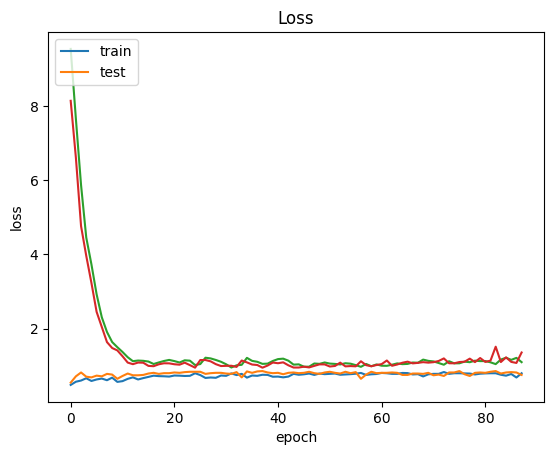

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
